# 相关性还是因果效应？

假设您获得了有关治疗和结果的一些数据。 Can you determine whether the treatment causes the outcome, or the correlation is purely due to another common cause?

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../../"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

## 数据集

让我们创建一个神秘数据集，我们需要为其确定是否存在因果效应。它是从以下两个模型之一生成的：

* **Model 1**: Treatment does cause outcome. 
* **Model 2**: Treatment does not cause outcome. 观察到的相关性都是由于共同原因造成的。

也就是说两个模型的 treatment and outcome 都具备相关性，但是其相关性的来源不相同。

In [90]:
rvar = 1 if np.random.uniform() >0.5 else 0 # 是否具备因果效应, 它要么是0要么是1
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar, sd_error=0.2)                                               
df = data_dict['df']                                                                                 
print(df[["Treatment", "Outcome", "w0"]].head()) 
rvar
# data_dict.keys()
# data_dict['gml_graph'], data_dict['ate'], data_dict['common_causes_names'], data_dict['time_val']

   Treatment    Outcome        w0
0   5.813169  11.124906 -0.261496
1   9.915709  19.694752  3.890721
2   9.874701  19.852529  3.829520
3  10.082831  20.137682  3.983658
4   7.479847  15.629233  1.899290


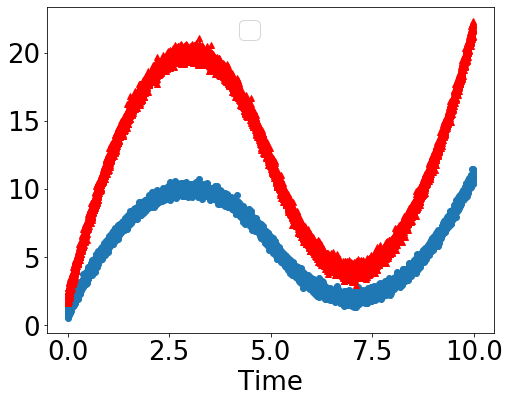

In [91]:
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])                                                       

## Does Treatment cause Outcome?

Using DoWhy to resolve the mystery: *Does Treatment cause Outcome?* 对于该观测数据，我们如下的方法可以准确估计模拟数据中的因果效应。

### STEP 1: Model the problem as a causal graph

初始化因果模型。

In [92]:
model= CausalModel(                                                                                                                      
        data=df,                                                                                                                         
        treatment=data_dict["treatment_name"],                                                                                           
        outcome=data_dict["outcome_name"],                                                                                               
        common_causes=data_dict["common_causes_names"],                                                                                  
        instruments=data_dict["instrument_names"],
        proceed_when_unidentifiable=True)                                                                                       
model.view_model(layout="dot")                                                                                                                                                                                                                                             

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Treatment'] on outcome ['Outcome']


显示存储在本地文件 “causal_model.png” 中的因果图

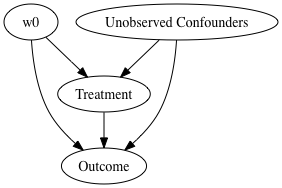

In [93]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### STEP 2: Identify causal effect using properties of the formal causal graph

使用因果图来识别因果效应。

In [94]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['w0', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(Expectation(Outcome|w0))
d[Treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)
### Estimand : 2
Estimand name: iv
No such variable found!



### STEP 3: Estimate the causal effect

Once we have identified the estimand, 我们可以使用任何统计方法来估计因果效应。为了简单起见，让我们使用线性回归。



INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


Causal Estimate is 0.9939024153048353


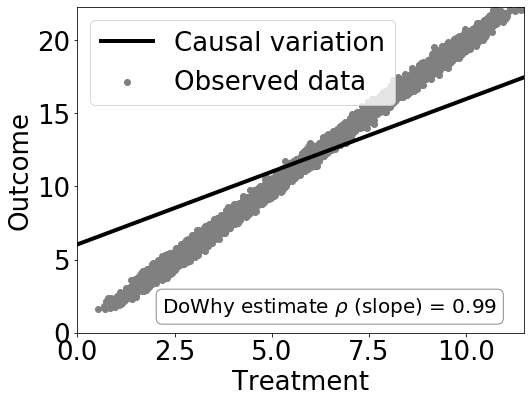

In [95]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect                                                                                                 
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

检查估计是否正确

In [96]:
print("DoWhy estimate is " + str(estimate.value)) 
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is 0.9939024153048353
Actual true causal effect was 1


### Step 4: Refuting the estimate

我们还可以反驳该估计值，以检查其是否符合假设（*aka* 敏感性分析）。

1) 添加一个随机的共因变量

In [97]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0+w_random


Refute: Add a Random Common Cause
Estimated effect:(0.9939024153048353,)
New effect:(0.9940274254487518,)



2) Replacing treatment with a random (placebo) variable

In [98]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~placebo+w0


Refute: Use a Placebo Treatment
Estimated effect:(0.9939024153048353,)
New effect:(-0.00023549427292834935,)



3) 删除数据的随机子集

In [99]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Outcome~Treatment+w0


Refute: Use a subset of data
Estimated effect:(0.9939024153048353,)
New effect:(0.9953760162895797,)



As you can see, our causal estimator is robust to simple refutations.